**Inductive Learning**  
: Training dataset만 모델이 볼 수 있고, 학습도 여기서만 진행. 전형적인 Supervised learning의 setting과 동일.



**Transductive Learning**  
: Train, Test dataset을 전부 볼 수 있지만, 학습은 Train dataset에서만 진행.

In [1]:
# OPTIONS
epochs = 300

# **I.** Data load

In [2]:
from torch_geometric.datasets import PPI

train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".", split='val')
test_dataset = PPI(root=".", split='test')

In [3]:
from torch_geometric.data import Batch
from torch_geometric.loader import NeighborLoader

# Note that there are 20 training graphs.
# Unify all the training graphs in a single set, by using `Batch.from_data_list()`.
# Use for link prediction task.

# train_data = Batch.from_data_list(train_dataset)

# loader = NeighborLoader(
#     train_data, 
#     batch_size=2048, 
#     shuffle=True, 
#     num_neighbors=[20, 10], 
#     num_workers=2, 
#     persistent_workers=True
# )

In [4]:
from torch_geometric.loader import DataLoader 

# batch_size : the number of graphs in each batch.
train_loader = DataLoader(train_dataset, batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

In [5]:
for i, subgraph in enumerate(train_loader):
    print(f"Subgraph {i}: {subgraph}")

Subgraph 0: DataBatch(x=[3144, 50], edge_index=[2, 62022], y=[3144, 121], batch=[3144], ptr=[3])
Subgraph 1: DataBatch(x=[4602, 50], edge_index=[2, 125074], y=[4602, 121], batch=[4602], ptr=[3])
Subgraph 2: DataBatch(x=[2599, 50], edge_index=[2, 54378], y=[2599, 121], batch=[2599], ptr=[3])
Subgraph 3: DataBatch(x=[4311, 50], edge_index=[2, 114720], y=[4311, 121], batch=[4311], ptr=[3])
Subgraph 4: DataBatch(x=[3903, 50], edge_index=[2, 113906], y=[3903, 121], batch=[3903], ptr=[3])
Subgraph 5: DataBatch(x=[4279, 50], edge_index=[2, 110486], y=[4279, 121], batch=[4279], ptr=[3])
Subgraph 6: DataBatch(x=[5299, 50], edge_index=[2, 152522], y=[5299, 121], batch=[5299], ptr=[3])
Subgraph 7: DataBatch(x=[5120, 50], edge_index=[2, 145180], y=[5120, 121], batch=[5120], ptr=[3])
Subgraph 8: DataBatch(x=[5465, 50], edge_index=[2, 162584], y=[5465, 121], batch=[5465], ptr=[3])
Subgraph 9: DataBatch(x=[6184, 50], edge_index=[2, 185496], y=[6184, 121], batch=[6184], ptr=[3])


# **II.** Model

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
from torch_geometric.nn import GraphSAGE

model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2,
    out_channels=train_dataset.num_classes
).to(device)

In [8]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def fit():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs

        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)

In [9]:
from sklearn.metrics import f1_score

def test(loader):
    model.eval()
    data = next(iter(loader))
    out = model(data.x.to(device), data.edge_index.to(device))

    preds = (out > 0).float().cpu()
    y, pred = data.y.numpy(), preds.numpy()

    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

# **III.** Train

In [10]:
log = {'loss':[], 'f1_score':[]}
for epoch in range(epochs):
    log['loss'].append(fit())
    log['f1_score'].append(test(val_loader))
    if epoch % 50 == 0:
        print(f"Epoch {epoch:>3} | Train Loss: {log['loss'][-1]:.3f} | Val F1 Score: {log['f1_score'][-1]:.4f}")

Epoch   0 | Train Loss: 0.590 | Val F1 Score: 0.4125
Epoch  50 | Train Loss: 0.193 | Val F1 Score: 0.8387
Epoch 100 | Train Loss: 0.144 | Val F1 Score: 0.8777
Epoch 150 | Train Loss: 0.120 | Val F1 Score: 0.8961


KeyboardInterrupt: 

In [ ]:
print(f"Test F1 Score: {test(test_loader):.4f}")

Test F1 Score: 0.9341


# **IV.** Visualize train

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [ ]:
def visualize(log):
    loss = log['loss']
    f1_score = log['f1_score']
    epochs = range(1, len(loss) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    plt.suptitle(f'Inductive GrahpSAGE', fontweight='bold')

    # Loss subplot
    axes[0].plot(epochs, loss, label='Loss', color='skyblue')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Train Loss')
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[0].legend()

    # Accuracy subplot
    axes[1].plot(epochs, f1_score, label='F1 Score', color='orange')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title('Validation F1 Score')
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].legend()

    plt.tight_layout()
    plt.show()

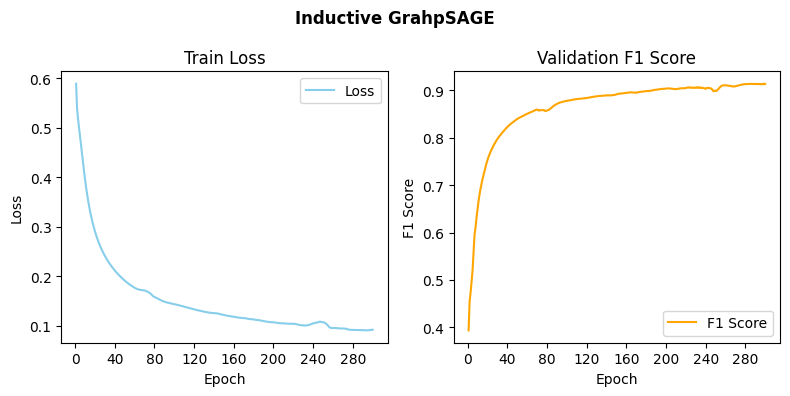

In [ ]:
visualize(log)